<a href="https://colab.research.google.com/github/victorgrrtj/dmwork/blob/main/Horse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho DM

##Carregando a Base

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Colab Notebooks/Projeto DM')

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer 
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as Pipe
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv('horsetrain.csv')
df_test = pd.read_csv('horsetest.csv')

In [ ]:
df_train

In [ ]:
df_test

## Análise Exploratória

In [ ]:
df_train.info()

In [ ]:
categorical_features = list(df_train.select_dtypes(include=['object']).columns)
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(15, 15), constrained_layout = True)
axe = ax.ravel()
for i, categorical_feature in enumerate(df_train[categorical_features]):
    df_train[categorical_feature].value_counts(dropna=False).plot(kind="bar", ax=axe[i], fontsize=15).set_title(categorical_feature)
fig.show()

In [ ]:
df_train.describe()

In [ ]:
for i in list(df_train.select_dtypes(include=['object']).columns):
    labels = df_train[i].unique()
    died = [(df_train[(df_train[i] == y) & (df_train['outcome'] == 'died')]['outcome'].count()) for y in labels]
    lived = [(df_train[(df_train[i] == y) & (df_train['outcome'] == 'lived')]['outcome'].count()) for y in labels]
    euthanized = [(df_train[(df_train[i] == y) & (df_train['outcome'] == 'euthanized')]['outcome'].count()) for y in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize = (5, 5))

    rects1 = ax.bar(x - width, lived, width, label='Lived')
    rects2 = ax.bar(x, died, width, label='Died')
    rects3 = ax.bar(x + width, euthanized, width, label='Euthanized')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(f'Count by outcome and {i}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

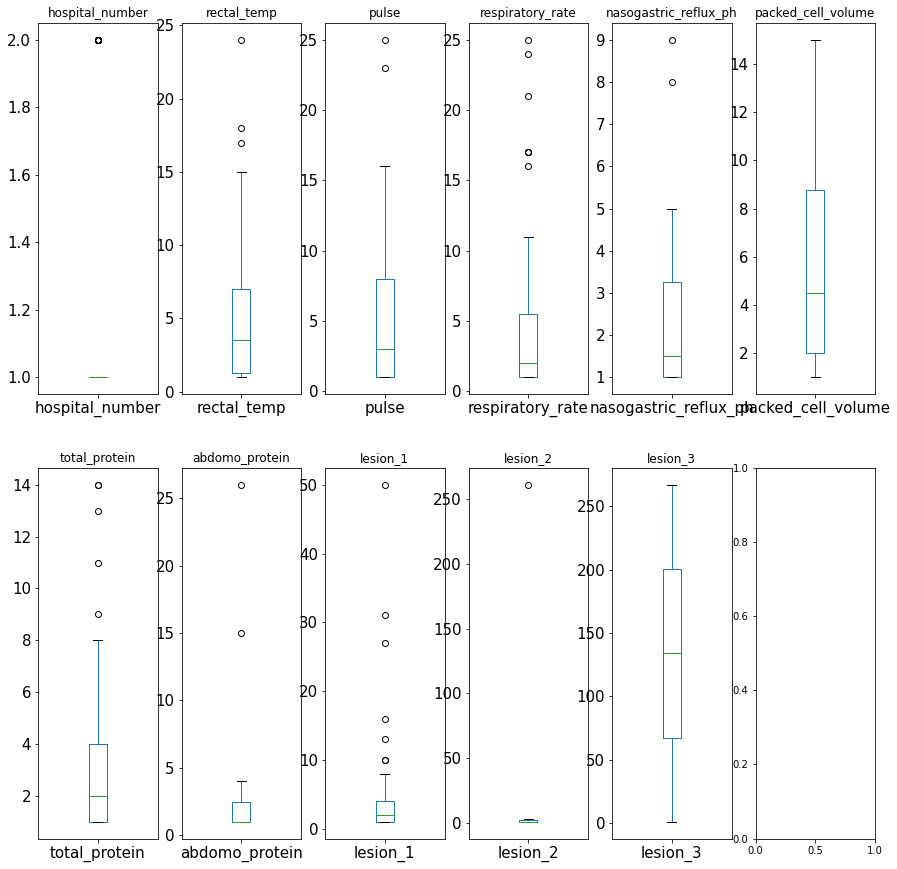

In [ ]:
numeric_features = list(df_train.select_dtypes(exclude=['object']).columns)
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15, 15))
axe = ax.ravel()
for i, numeric_feature in enumerate(df_train[numeric_features]):
    df_train[numeric_feature].value_counts().plot(kind="box", ax=axe[i], fontsize=15).set_title(numeric_feature)
plt.show()

In [ ]:
msno.matrix(df_train)

In [ ]:
msno.heatmap(df_train)

In [ ]:
df_train

In [ ]:
msno.bar(df_train)

In [ ]:
df_train_copy = df_train.copy()

In [ ]:
df_train_copy.info()

In [ ]:
df_train_copy = df_train.copy()
df_train_copy.drop(columns=['nasogastric_reflux_ph', 'hospital_number'], inplace=True)
subset = []
for i in list(df_train_copy.columns):
  if df_train_copy[i].isnull().values.any():
    subset.append(i)
for y in range(len(subset)):
  df_train_copy.dropna(thresh = y + 1, subset = subset, inplace=True)
  print(f"Para thresh = {y + 1} , o dataframe fica com {len(df_train_copy)} linhas. Perda de informação: {round(((299 - len(df_train_copy))/299) * 100, 2)}% ")
  df_train_copy = df_train.copy()

## Pré Processamento

In [5]:
# pré processamento na base de treino para excluir linhas com muitos dados faltantes
subset = []
for i in list(df_train.columns):
 if df_train[i].isnull().values.any():
  subset.append(i)
df_train.dropna(thresh = 9, subset = subset, inplace=True)

In [6]:
# define as colunas 'lesion_1', 'lesion_2', 'lesion_3' como categorias
def cols_to_categorical(base):
  cols_to_categorical = ['lesion_1', 'lesion_2', 'lesion_3']
  for col in base.columns:
    if col in cols_to_categorical:
      base[col] = base[col].astype('category')

In [7]:
# divide as bases em treino e teste
X_train = df_train.loc[:, df_train.columns != 'outcome']
y_train = df_train['outcome']
X_test = df_test.loc[:, df_train.columns != 'outcome']
y_test = df_test['outcome']

In [8]:
cols_to_categorical(X_train)
cols_to_categorical(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
print(X_train.shape)
print(X_test.shape)

(268, 27)
(89, 27)


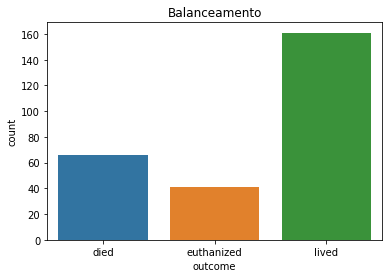

lived         161
died           66
euthanized     41
Name: outcome, dtype: int64


In [ ]:
# Balanceamento
sns.countplot(data=X_train, x=y_train)
plt.title('Balanceamento')
plt.show()
print(y_train.value_counts())

In [58]:
#RandomOverSampler
ros = RandomOverSampler(random_state=1)

#RandomUnderSampler
rus = RandomUnderSampler(random_state=1)

#deleta colunas com pouca/nenhuma informação
to_delete = ['hospital_number', 'nasogastric_reflux_ph']

# Classes numéricas - Preenche linhas vazias pela média e normaliza
numeric_features = [
 'rectal_temp',
 'pulse',
 'respiratory_rate', 
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein']
numeric_transformer = Pipe(steps=[
    ('imputernum', SimpleImputer()),
    ('scaler', StandardScaler())])

# Classes categóricas - Preenche linhas vazias pela moda e aplica one hot encoder
categorical_features = [
 'surgery',
 'age',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'abdomo_appearance',
 'surgical_lesion',
 'lesion_1',
 'lesion_2',
 'lesion_3',
 'cp_data']
categorical_transformer = Pipe(steps=[
  ('imputercat', SimpleImputer(strategy='most_frequent')),                                         
  ('hot', OneHotEncoder(handle_unknown='ignore'))])

#transforma a classe
preprocessor = ColumnTransformer(
    transformers=[
                  ('del', 'drop', to_delete),
                  ('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

## Modelagem

In [12]:
def predict_and_evaluate(X_test, y_test):

  y_pred = clf.predict(X_test) #inferência do teste

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  #F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred, average = 'weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred, y_test)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f")
  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['Lived', 'Died', 'Euthanized']) 
  ax.yaxis.set_ticklabels(['Lived', 'Died', 'Euthanized'])
  plt.show()

### Regressão Linear

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.7865168539325843
Kappa:  0.6613936724068883
F1:  0.799311643412767


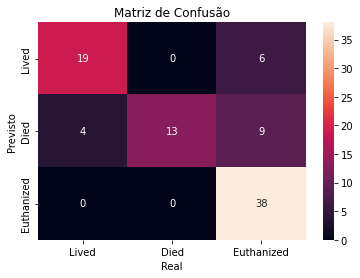

In [ ]:
## regressão logistica, RandomUnderSampler
ros = RandomUnderSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', LogisticRegression(max_iter=1000))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.8876404494382022
Kappa:  0.8049956178790535
F1:  0.8886972398825408


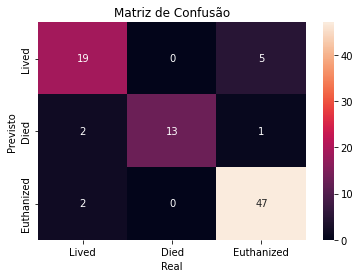

In [ ]:
## regressão logistica com RandomOverSampler
ros = RandomOverSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', LogisticRegression(max_iter=1000))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.9101123595505618
Kappa:  0.8310393925011865
F1:  0.9069689673622259


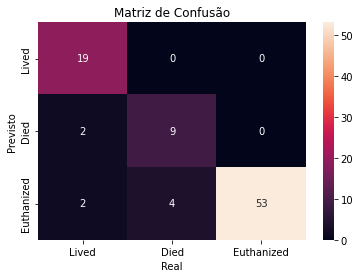

In [ ]:
## regressão logistica sem balanceamento

# pipeline cotendo o pré processamento e o classificador
clf = Pipe(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [36]:
ros = RandomOverSampler(random_state=1)

pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('ros', ros),
                   ('classiffier', LogisticRegression(random_state=1, max_iter=10000))])

param_grid = {'preprocessor__num__imputernum__strategy' : ['mean', 'median'],
              'classiffier__C' : [0.1, 10, 100],
              'classiffier__solver' : ['liblinear', 'saga']}
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

        died       0.76      0.83      0.79        23
  euthanized       0.61      0.85      0.71        13
       lived       0.91      0.79      0.85        53

    accuracy                           0.81        89
   macro avg       0.76      0.82      0.78        89
weighted avg       0.83      0.81      0.81        89



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [37]:
grid_search.best_params_

{'classiffier__C': 0.1,
 'classiffier__solver': 'saga',
 'preprocessor__num__imputernum__strategy': 'mean'}

Acurácia:  0.8876404494382022
Kappa:  0.8019581664441477
F1:  0.8881652055809359


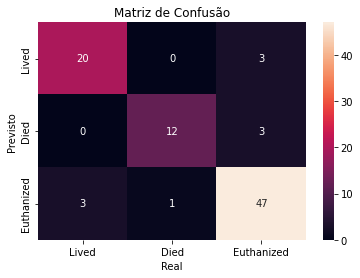

In [ ]:
## regressão logistica sem balanceamento

# pipeline cotendo o pré processamento e o classificador
clf_reg2 = Pipe(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, C=0.1, solver = 'saga'))])

clf_reg2.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

### SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.7865168539325843
Kappa:  0.65234375
F1:  0.7918622814756052


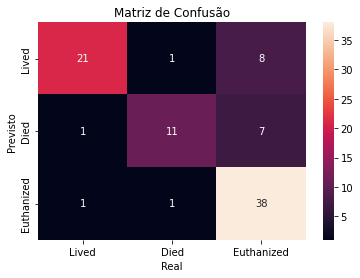

In [ ]:
## SVM, RandomUnderSampler
ros = RandomUnderSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', SVC(random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.8651685393258427
Kappa:  0.7416545718432511
F1:  0.853812217727375


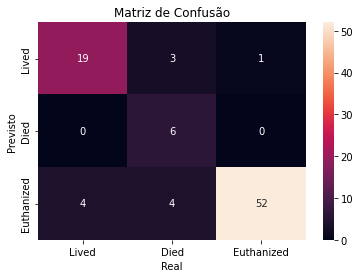

In [ ]:
## SVM, sem balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[('preprocessor', preprocessor),
                  ('classifier', SVC(random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.8876404494382022
Kappa:  0.8019581664441477
F1:  0.8881652055809359


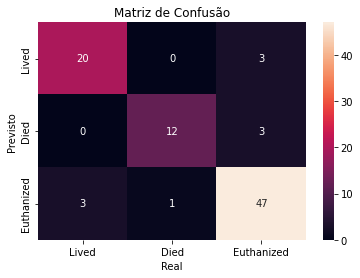

In [ ]:
## regressão logistica, RandomUnderSampler. Ficou melhor com drop = 'first'
ros = RandomOverSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_reg = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', SVC(random_state=1))])

clf_reg.set_params(preprocessor__cat__hot__handle_unknown = 'error',
                  preprocessor__cat__hot__drop = 'first')
clf_reg.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [57]:
#GridSearch sem Balanceamento
pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('classiffier', SVC(random_state=1))])

param_grid = {'classiffier__C': [0.1, 1, 10, 100, 1000],
              'classiffier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classiffier__kernel': ['rbf']}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        died       1.00      0.83      0.90        23
  euthanized       0.83      0.77      0.80        13
       lived       0.91      1.00      0.95        53

    accuracy                           0.92        89
   macro avg       0.92      0.87      0.89        89
weighted avg       0.92      0.92      0.92        89



In [59]:
#GridSearch sem Balanceamento

pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('ros', ros),
                   ('classiffier', SVC(random_state=1))])

param_grid = {'classiffier__C': [0.1, 1, 10, 100, 1000],
              'classiffier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classiffier__kernel': ['rbf']}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        died       1.00      0.91      0.95        23
  euthanized       0.87      1.00      0.93        13
       lived       1.00      1.00      1.00        53

    accuracy                           0.98        89
   macro avg       0.96      0.97      0.96        89
weighted avg       0.98      0.98      0.98        89



In [60]:
grid_search.best_params_

{'classiffier__C': 100,
 'classiffier__gamma': 0.01,
 'classiffier__kernel': 'rbf'}

Acurácia:  0.8876404494382022
Kappa:  0.8019581664441477
F1:  0.8890891240318535


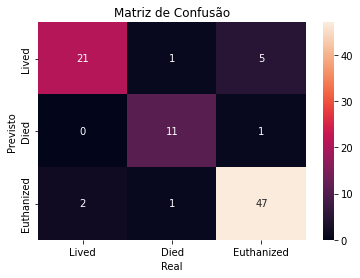

In [61]:
## regressão logistica, RandomUnderSampler. Ficou melhor com drop = 'first'

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_reg = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', SVC(random_state=1, C=100, gamma=0.01, kernel='rbf'))])

clf_reg.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

### Decision Tree

Acurácia:  0.6629213483146067
Kappa:  0.4927811550151976
F1:  0.6705412765268044


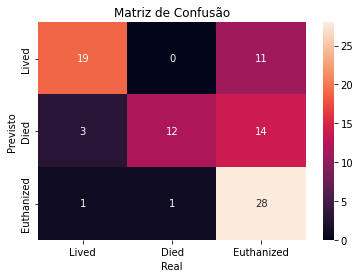

In [50]:
## Decision Tree, RandomUnderSampler

ros = RandomUnderSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', DecisionTreeClassifier(min_samples_leaf=5, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.797752808988764
Kappa:  0.6337448559670782
F1:  0.7958733401430031


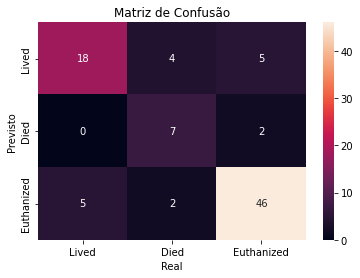

In [ ]:
## Decision Tree sem Balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(min_samples_leaf=5, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.6629213483146067
Kappa:  0.4927811550151976
F1:  0.6705412765268044


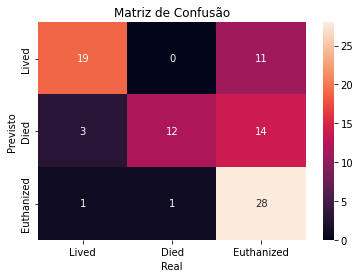

In [51]:
## Decision Tree, RandomOverSampler

ros = RandomOverSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_tree = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', DecisionTreeClassifier(min_samples_leaf=5, random_state=1))])

clf_tree.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [52]:
#GridSearch sem Balanceamento
pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('classiffier', DecisionTreeClassifier(random_state=1))])

param_grid = {'classiffier__criterion': ['gini', 'entropy'],
              'classiffier__max_depth': [2,4,6,8,10,12]}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        died       0.78      0.91      0.84        23
  euthanized       0.92      0.85      0.88        13
       lived       0.94      0.89      0.91        53

    accuracy                           0.89        89
   macro avg       0.88      0.88      0.88        89
weighted avg       0.89      0.89      0.89        89



In [41]:
grid_search.best_params_

{'classiffier__criterion': 'gini', 'classiffier__max_depth': 6}

Acurácia:  0.8876404494382022
Kappa:  0.8019581664441477
F1:  0.8890891240318535


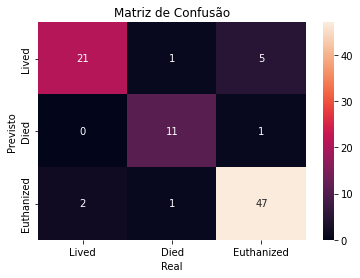

In [53]:
## Decision Tree com os melhores parâmetros sem Balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='gini',max_depth=6 ,random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [54]:
#GridSearch com OverSampler
ros = RandomOverSampler(random_state=1)

pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('ros', ros),
                   ('classiffier', DecisionTreeClassifier(random_state=1))])

param_grid = {'classiffier__criterion': ['gini', 'entropy'],
              'classiffier__max_depth': [2,4,6,8,10,12]}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        died       0.96      0.96      0.96        23
  euthanized       0.87      1.00      0.93        13
       lived       0.98      0.94      0.96        53

    accuracy                           0.96        89
   macro avg       0.93      0.97      0.95        89
weighted avg       0.96      0.96      0.96        89



In [55]:
grid_search.best_params_

{'classiffier__criterion': 'entropy', 'classiffier__max_depth': 10}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.8876404494382022
Kappa:  0.8019581664441477
F1:  0.8890891240318535


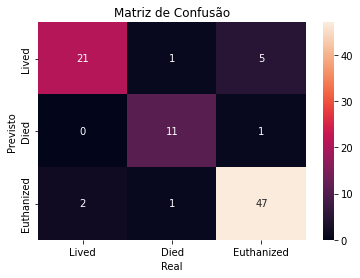

In [46]:
# Decision Tree com melhores parâmetros e OverSampler
ros = RandomOverSampler(random_state=1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_tree = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', DecisionTreeClassifier(criterion='entropy',max_depth=10 ,random_state=1))])

clf_tree.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

### Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.7078651685393258
Kappa:  0.523279769262464
F1:  0.7192577556859047


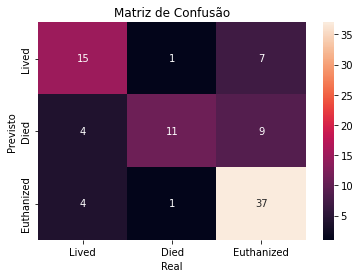

In [17]:
#RF com UnderSampler

ros = RandomUnderSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(min_samples_leaf=5, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.7865168539325843
Kappa:  0.5668545081967213
F1:  0.7613291850036807


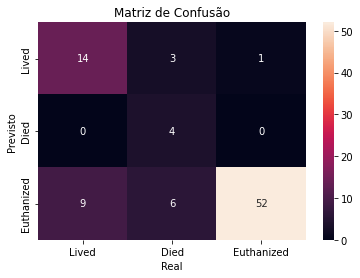

In [18]:
#RF sem Balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(min_samples_leaf=5, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.9101123595505618
Kappa:  0.8433098591549295
F1:  0.9113389816127899


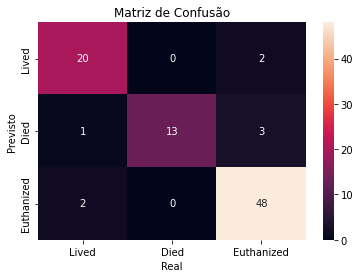

In [16]:
#RF com OverSampler

ros = RandomOverSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(min_samples_leaf=5, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [21]:
#GridSearch sem Balanceamento
pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('classiffier', RandomForestClassifier(random_state=1))])

param_grid = {'classiffier__n_estimators': [20, 50, 100, 150, 200, 300, 400, 500],
              'classiffier__max_features': [3,4,8,9,10,11]}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        died       1.00      0.91      0.95        23
  euthanized       1.00      1.00      1.00        13
       lived       0.96      1.00      0.98        53

    accuracy                           0.98        89
   macro avg       0.99      0.97      0.98        89
weighted avg       0.98      0.98      0.98        89



In [22]:
grid_search.best_params_

{'classiffier__max_features': 11, 'classiffier__n_estimators': 50}

Acurácia:  0.9775280898876404
Kappa:  0.9591180523656408
F1:  0.9772254378995952


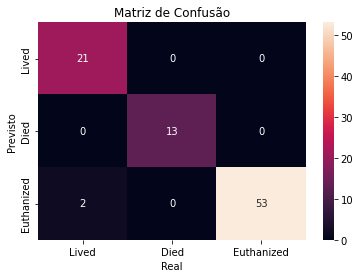

In [24]:
#RF com melhores parâmetros sem Balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_features=11, n_estimators=50, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.9775280898876404
Kappa:  0.9591180523656408
F1:  0.9772254378995952


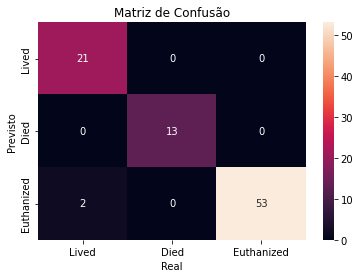

In [26]:
#RF com melhores parâmetros e OverSampler

ros = RandomOverSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(max_features=11, n_estimators=50, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.8314606741573034
Kappa:  0.7168010182435298
F1:  0.8337011771000534


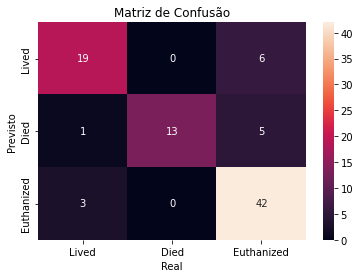

In [27]:
#RF com melhores parâmetros e UnderSampler

ros = RandomUnderSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(max_features=11, n_estimators=50, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [28]:
ros = RandomOverSampler(random_state=1)

pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('ros', ros),
                   ('classiffier', RandomForestClassifier(random_state=1))])

param_grid = {'classiffier__n_estimators': [20, 50, 100, 150, 200, 300, 400, 500],
              'classiffier__max_features': [3,4,8,9,10,11]}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

        died       1.00      0.91      0.95        23
  euthanized       1.00      1.00      1.00        13
       lived       0.96      1.00      0.98        53

    accuracy                           0.98        89
   macro avg       0.99      0.97      0.98        89
weighted avg       0.98      0.98      0.98        89



In [29]:
grid_search.best_params_

{'classiffier__max_features': 4, 'classiffier__n_estimators': 100}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.9775280898876404
Kappa:  0.9591180523656408
F1:  0.9772254378995952


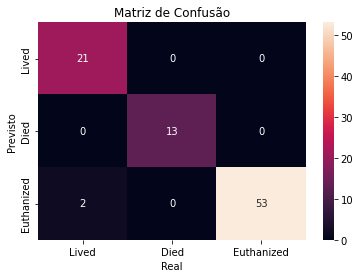

In [30]:
#RF com melhores parâmetros e OverSampler

ros = RandomOverSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(max_features=4, n_estimators=100, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

Acurácia:  0.9775280898876404
Kappa:  0.9591180523656408
F1:  0.9772254378995952


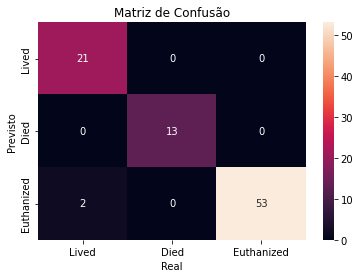

In [31]:
#RF com melhores parâmetros sem Balanceamento

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_features=4, n_estimators=100, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Acurácia:  0.8202247191011236
Kappa:  0.7048092868988391
F1:  0.8261267369159371


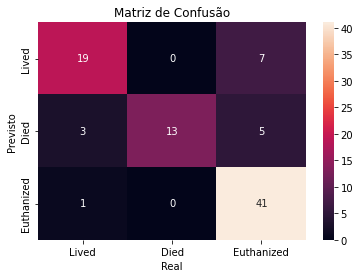

In [32]:
#RF com melhores parâmetros e OverSampler

ros = RandomUnderSampler(random_state=1)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipe(steps=[
                      ('preprocessor', preprocessor),
                      ('ros', ros),
                      ('classifier', RandomForestClassifier(max_features=4, n_estimators=100, random_state=1))])

clf.fit(X_train, y_train)
predict_and_evaluate(X_test, y_test)

In [ ]:
#GridSearch com UnderSampler

ros = RandomUnderSampler(random_state=1)

pipe = Pipe(steps=[('preprocessor', preprocessor),
                   ('ros', ros),
                   ('classiffier', RandomForestClassifier(random_state=1))])

param_grid = {'classiffier__n_estimators': [20, 50, 100, 150, 200, 300, 400, 500],
              'classiffier__max_features': [3,4,8,9,10,11]}

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))